In [1]:
import numpy as np
import pandas as pd
import sklearn 
from sklearn import preprocessing
from matplotlib import pyplot as plt
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('adult.data')
replace_nans = {}
for column in df.columns:
    if df.dtypes[column] == np.object:
        replace_nans[column] = np.argmax(df[column].value_counts())
        df[column].replace(to_replace=' ?', value=replace_nans[column], inplace=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [3]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

encoded_data, encoders = number_encode_features(df)
df = encoded_data
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0


In [4]:
X_train, Y_train = df[df.columns[:-1]].values, df[df.columns[-1]].values

In [5]:
df_test = pd.read_csv('adult.val')
for column in df_test.columns:
    if df_test.dtypes[column] == np.object:
        df_test[column].replace(to_replace=' ?', value=replace_nans[column], inplace=True)

In [6]:
def encode_test(df):
    result = df.copy()
    for column in result.columns:
        if result.dtypes[column] == np.object:
            result[column] = encoders[column].transform(result[column])
    return result

df_test = encode_test(df_test)
X_test = np.array(df_test)
df_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,51,3,335997,11,9,2,2,0,4,1,0,1902,40,38
1,50,3,98227,11,9,0,2,1,4,1,0,0,40,38
2,48,1,204629,10,16,2,9,0,4,1,15024,0,45,1
3,32,3,246038,9,13,4,9,1,4,1,0,0,40,38
4,42,3,67243,3,2,2,0,0,4,1,0,0,55,31


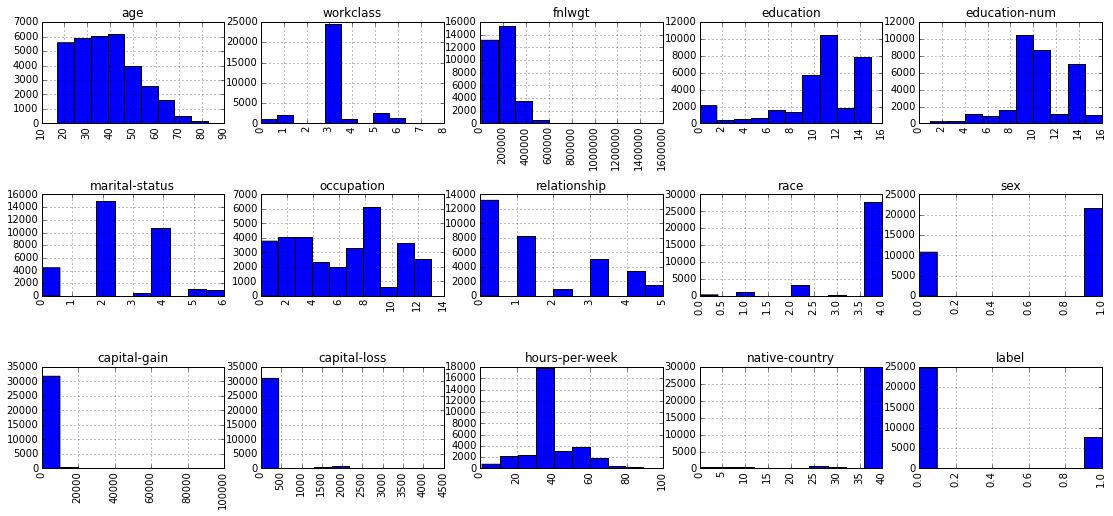

In [7]:
fig = plt.figure(figsize=(19,8))
cols = 5
rows = ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

## Decision tree (CART)
ftp://public.dhe.ibm.com/software/analytics/spss/support/Stats/Docs/Statistics/Algorithms/13.0/TREE-CART.pdf

In [8]:
class Node:
    def __init__(self, col=-1,value=None,result=None,left=None,right=None, positive=0, negative=0):
        self.col=col # column index of criteria being tested
        self.value=value # vlaue necessary to get a true result
        self.result=result # dict of results for a branch, None for everything except endpoints
        self.positive = positive
        self.negative = negative

In [9]:
from scipy.stats import entropy as scipy_entropy

def gini(left, right):
    return 1 - (left / float(left + right)) ** 2 - (right / float(left + right)) ** 2

def twoing(left,right):
    p = get_probabilities(left,right)
    p2 = ll / ll + lr
    p4 = rr / rr + rl
    p3 = lr / ll + lr
    p1 = lr + rr / all
    
    return p[6] * p[7] * (abs(p[2] - p[4]) + abs(p[1] - p[3])) ** 2

def entropy(left, right):
    x = np.array([left / float(left + right), right / float(left + right)])
    return - np.sum(x*np.log2(x))

In [10]:
class CART(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    
    def __init__(self, leaf_min_size = 10, tree_depth = 20, criterion='gini', 
                 min_improvement=0.001, beta = 0.6):
        self.leaf_min_size = leaf_min_size
        self.tree_depth = tree_depth
        self.criterion = criterion
        self.min_improvement = min_improvement
        self.tree = {}
        self.beta = beta
    
    def fit(self, X_train, y_train, beta=0.6):
        self.X_train = X_train
        self.y_train = y_train
        self.build(X_train, y_train, 1, 0)
        return self
    
    def build(self, X, y, node_num, current_tree_depth):
        best_gain = best_value = best_col = best_index = 0
        r = np.count_nonzero(y)
        l = y.shape[0] - r
        cur_gain = self.impurity(r, l)
        for col in range(X.shape[1]):
            order = np.argsort(X[:,col], axis=0)
            X = X[order]
            y = y[order]
            gain = 0
            index = 0
            value = 0
            for v in sorted(set([X[row, col] for row in range(len(X))])):
            #for i in range(self.leaf_min_size, X.shape[0] - self.leaf_min_size):
                i = X[:,col].tolist().index(v)
                if i != 0:
                    left = np.arange(i)
                    right = np.arange(i, X.shape[0])
                    p = float(left.shape[0]) / y.shape[0]
                    lr = np.count_nonzero(y[left])
                    ll = left.shape[0] - lr
                    rr = np.count_nonzero(y[right])
                    rl = right.shape[0] - rr
                    cur = cur_gain - p * self.impurity(ll, lr) - (1 - p) * self.impurity(rl, rr)
                    if cur > gain:
                        value = v
                        gain = cur
                        index = i

            if gain > best_gain:
                best_gain = gain
                best_value = value
                best_col = col
                best_index = index
        pos = np.count_nonzero(y)
        neg = y.shape[0] - pos
        #i = X[:,best_col].tolist().index(best_value)
        if self.stopping_criterion(X, y, best_gain, best_index, current_tree_depth):
            self.tree[node_num] = Node(positive = pos, negative = neg, result = 0 if np.count_nonzero(y) < self.beta * y.shape[0] else 1)
        else:
            order = np.argsort(X, axis=0)[:, best_col]
            X = X[order]
            y = y[order]
            X_left_set =  X[:best_index]
            X_right_set = X[best_index:]
            y_left_set =  y[:best_index]
            y_right_set = y[best_index:]
            self.build(X_left_set, y_left_set, 2 * node_num, current_tree_depth + 1)
            self.build(X_right_set, y_right_set, 2 * node_num + 1, current_tree_depth + 1)
            self.tree[node_num] = Node( col = best_col, value = best_value, 
                                      positive = pos, negative = neg)
    
    def stopping_criterion(self, X, y, gain, index, current_tree_depth):
        if current_tree_depth >= self.tree_depth:
            return True
        if y.shape[0] <= self.leaf_min_size:
            return True
        if np.unique(y).shape[0] == 1:
            return True
        if index < self.leaf_min_size or X.shape[0] < self.leaf_min_size + index:
            return True
        if gain <= self.min_improvement:
            return True
        return False

    def impurity(self, left, right):
        if self.criterion == 'gini':
            return gini(left, right)
        elif self.criterion == 'entropy':
            return entropy(left, right)
        else:
            #You could insert here call for ordered Twoing
            raise ValueError("Unknown criterion type!")
    
    
    def predict(self, X_test):
        y_pred = numpy.zeros(X_test.shape[0])
        for i in range(X_test.shape[0]):
            x = X_test[i]
            node_n = 1
            node = self.tree[1]
            while node.result == None:
                if x[node.col] < node.value:
                    node_n = 2 * node_n
                else:
                    node_n = 2 * node_n + 1
                node = self.tree[node_n]
            y_pred[i] = node.result
        return y_pred

In [15]:
%%time
cart = CART(10, 20, criterion='gini')
%time cart = cart.fit(X_train, Y_train, beta=0.5)
%time y_pred = cart.predict(X_test)

CPU times: user 3min 49s, sys: 4.09 s, total: 3min 53s
Wall time: 3min 53s
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 29.4 ms
CPU times: user 3min 49s, sys: 4.09 s, total: 3min 53s
Wall time: 3min 53s


In [11]:
def accuracy(y_true, y_predict):
    score = 1 - float(np.count_nonzero(np.array(y_true) - y_predict)) / len(y_true)
    return score

In [12]:
def cross_validation(estimator, X, Y, fit_params=None, predict_params=None, cv_fold=5):
    def extract_part(data, i):
        length = data.shape[0]
        part_len = length / cv_fold
        upper_bound = part_len * (i + 1)
        lower_bound = part_len * i
        
        part = np.take(data, range(int(lower_bound), int(upper_bound)), axis=0)
        other = np.take(data, list(range(int(lower_bound))) + list(range(int(upper_bound) + 1, length)), axis=0)
        
        return other, part
    
    scores = []
    if fit_params == None:
        fit_params = {}
    if predict_params == None:
        predict_params = {}
    for i in range(cv_fold):
        train, test = extract_part(X, i)
        train_labels, test_labels = extract_part(Y, i)
        
        estimator = estimator.fit(train, train_labels, **fit_params)
        predict_labels = estimator.predict(test, **predict_params)
                
        scores.append(accuracy(test_labels, predict_labels))
    return np.mean(scores)



In [20]:
score = cross_validation(CART(10, 20, 'gini'), X_train, Y_train)
print(score)

0.854580651587


In [26]:
criteria = ['entropy', 'gini']
scores = []
for c in criteria:
    score = cross_validation(CART(10, 20, c), X_train[:10000], Y_train[:10000])
    print(score)
    scores.append(score)
print('scores =', scores)

0.8476
0.8493
scores = [0.84759999999999991, 0.84930000000000005]


In [126]:
y_best = np.zeros(X_test.shape[0])
for n in [0, 15, 20]:
    card = CART(n, 20, criterion='gini2')
    cart = cart.fit(X_train[:1000], Y_train[:1000])
    print(n, result_accuracy(y_pred))
    if result_accuracy(y_pred) > result_accuracy(y_best):
        y_best = y_pred

0 0.6424581005586593
15 0.6424581005586593
20 0.6424581005586593


In [263]:
pd.DataFrame(y_pred, dtype=int, columns=['label']).to_csv('res%.4f.csv' % result_accuracy(y_pred), index_label='id')

### Optional part: Pruning
More information you could get here: http://www.dcc.fc.up.pt/~ltorgo/PhD/th4.pdf

In [ ]:
for node in cart.tree:
    if cart.tree[node].result != None:
        print(cart.tree[node].positive, cart.tree[node].negative)

In [61]:
def EC(tree, alpha):
    samples_cnt = 0
    err_cnt = 0
    res = 0
    for node_num in tree:
        if tree[node_num].result != None:
            node = tree[node_num]
            samples_cnt += node.positive
            samples_cnt += node.negative
            err_cnt += node.positive * (0 == node.result) + node.negative * (1 == node.result)
            res += alpha
    if samples_cnt != 0:
        return float(err_cnt) / samples_cnt + res
    else:
        return 100000000

def add_leaf(old_node, node_num, tree):
    result = 1 if old_node.positive >= old_node.negative else 0
    tree[node_num] = Node(old_node.col, old_node.value, result, old_node.positive, old_node.negative)
    return tree

def delete_children(node_num, tree):
    if not node_num in tree:
        return tree
    delete_children(node_num * 2, tree)
    delete_children(node_num * 2 + 1, tree)
    if node_num * 2 in tree:
        del tree[node_num * 2]
    if node_num * 2 + 1 in tree:
        del tree[node_num * 2 + 1]
    return tree

def add_children(node_num, tree, old_tree):
    while node_num * 2 in old_tree:
        add_children(node_num * 2, tree)
        add_children(node_num * 2 + 1, tree)
        tree[node_num * 2] = old_tree[node_num * 2]
        tree[node_num * 2 + 1] = old_tree[node_num * 2 + 1]
    return tree

def pruning(cart_tree, alpha):
    best_EC = len(cart_tree.tree) * alpha + 2
    old_tree = cart_tree.tree.copy()
    new_tree = cart_tree.tree.copy()
    tree_changed = True
    while tree_changed:
        tree_changed = False
        leafs = []
        for node_n in new_tree:
            if new_tree[node_n].result != None:
                leafs.append(node_n)
        leafs = sorted(leafs, reverse=True)
        for node_n in leafs:
            n = node_n // 2
            if not n in new_tree:
                # node was already deleted
                continue
                
            add_leaf(new_tree[n], n, new_tree)
            delete_children(n, new_tree)
#             print EC(new_tree, alpha)
            if EC(new_tree, alpha) <= best_EC:
                tree_changed = True
                best_EC = EC(new_tree, alpha)
                delete_children(n, old_tree)
                add_leaf(old_tree[n], n, old_tree) 
            else:
                new_tree = old_tree.copy()
                
#         print best_EC, len(new_tree)
    cart_tree.tree = new_tree.copy()
    return cart_tree

# Predictions

In [189]:
ones = np.where(Y_train == 1)[0]
np.random.shuffle(ones)
zeros = np.where(Y_train == 0)[0]
np.random.shuffle(zeros)

indexes = np.concatenate((ones[:6000], zeros[:4000]))
Y_train_disbalanced = Y_train[indexes]
X_train_disbalanced = X_train[indexes]

In [248]:
#%time cart = cart.fit(X_train, Y_train)
#saved_tree_instance = cart.tree.copy()
#print(beta, result_accuracy(y_pred))
#if result_accuracy(y_pred) > result_accuracy(y_best):
#    y_best = y_pred
#cart.tree = saved_tree_instance.copy()
for k in [3., 4., 5.]:
    pruned = pruning(cart, 0.0001 * k)
    print(len(pruned.tree), len(saved_tree_instance))
    y_pred = pruned.predict(X_test)
    print(result_accuracy(y_pred))
    if result_accuracy(y_pred) > result_accuracy(y_best):
        y_best = y_pred

7 275
0.5991620111731844
7 275
0.5991620111731844
7 275
0.5991620111731844


In [66]:
%time pruned = pruning(cart, 0.5)
y_pred = pruned.predict(X_test)
print(result_accuracy(y_pred))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 280 µs
0.4338919925512104


In [205]:
pd.DataFrame(y_best, dtype=int, columns=['label']).to_csv('res%.4f.csv' % result_accuracy(y_best), index_label='id')

criterion = 'gini2' <br>
min_leaf_size = 17

# Visualization

In [18]:
from IPython.core.display import Image, display

In [16]:
# Create a picture of your tree, using GraphViz

graph = "strict digraph {\n"
for node in cart.tree:
    v = cart.tree[node]
    if v.result == None:
        
        graph += '%d [label="predict by column %d by value = %d"' % (node, v.col, v.value)
    else:
        graph += '%d [label="class %d", color=red' % (node, v.result)
    graph += ',];\n'
    
for node in cart.tree:
    v = cart.tree[node]
    if v.result == None:
        graph += '%d -> %d;\n' % (node, 2 * node)
        graph += '%d -> %d;\n' % (node, 2 * node + 1)
graph += '}'

value = """strict digraph {
1 [label="hi\nhi", shape="box"];
2;
3[label="hihi"];
4;
5;
1 -> 2;
1 -> 3;
1 -> 5;
2 -> 4;
}
"""

open('tree.dot', 'w').write(graph)

21893

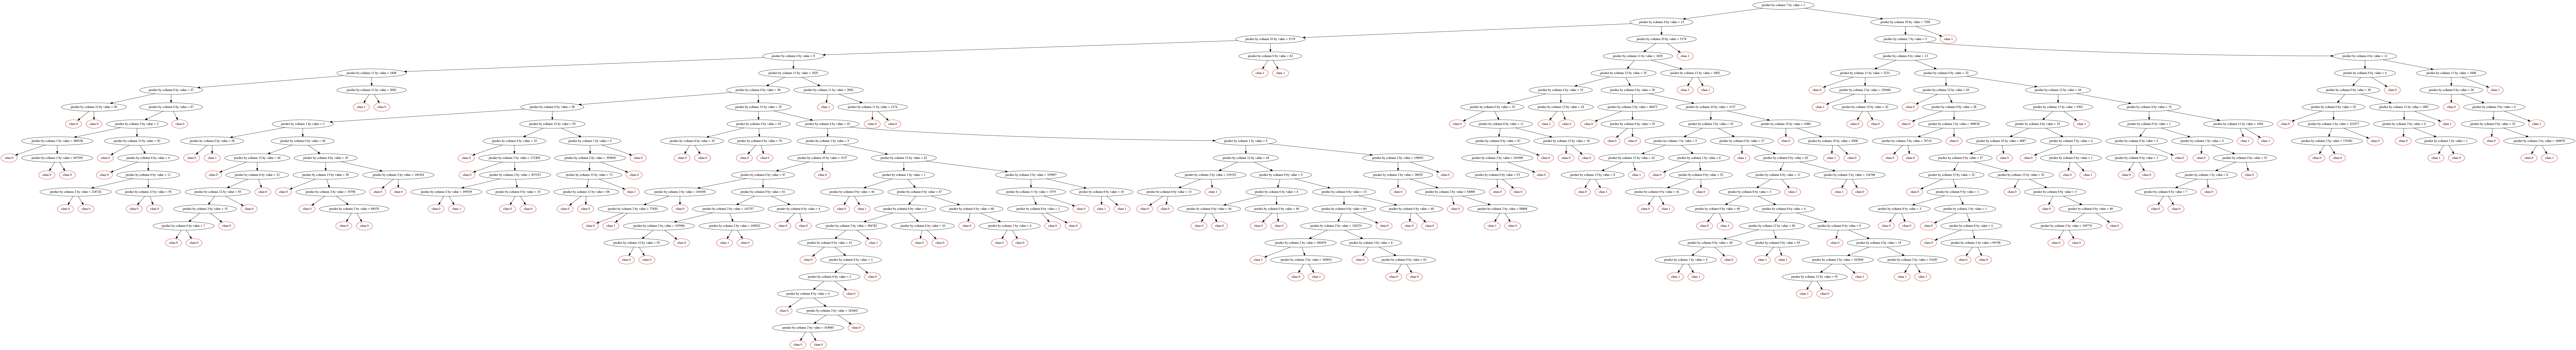

In [19]:
!dot -Tpng tree.dot -o tree.png
Image('tree.png')

## Tree comparison visualisation

In [4]:
# 1) Сгенерируйте 3 двумерных двухклассовых выборки
# 2) Обучите на нах классификаторы: Ваше деврево, kNN
# 3) С постоянным шагом по каждой координате проведите классфикацию точек плоскости
# 4) Какой классфикатор работает лучше, в чем преимущества и недостатки Решаюших деревьев и KNN для этих выборок?

    
# --------
#1) Используйте KNN -- http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
#2) Для генерации выборки используйте from sklearn.datasets import make_moons, make_circles
#3) Пример решения http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

# Example:
from IPython.display import Image
from IPython.display import display
display(Image(url="http://scikit-learn.org/stable/_images/plot_classifier_comparison_001.png"))

## Tree bagging
The training algorithm for random forests applies the general technique of bootstrap aggregating, or bagging, to tree learners. Given a training set $X=x_1,...,x_n$ with responses $Y = y_1, ..., y_n$, bagging repeatedly ($ B $ times) selects a random sample with replacement of the training set and fits trees to these samples.
After training, predictions for unseen samples $ x' $ can be made by averaging the predictions from all the individual regression trees on $x'$:

$$ \hat{f} = \frac{1}{B} \sum_{b=1}^B \hat{f}_b (x') $$

or by taking the majority vote in the case of decision trees.

This bootstrapping procedure leads to better model performance because it decreases the variance of the model, without increasing the bias. This means that while the predictions of a single tree are highly sensitive to noise in its training set, the average of many trees is not, as long as the trees are not correlated. Simply training many trees on a single training set would give strongly correlated trees (or even the same tree many times, if the training algorithm is deterministic); bootstrap sampling is a way of de-correlating the trees by showing them different training sets.

In [ ]:
def bagging(X, y, size):
    #Implement random sampling here
    sample_X, sample_y = X[:size], y[:size]
    return sample_X, sample_y

In [ ]:
class Forest(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    def __init__(self, num_trees):
        self.num_trees = num_trees
        self.trees = []
    
    def fit(self, X_train, y_train):
        '''
        Create trees here, using bagging.
        '''
        return self
    
    def predict(self, X_test):
        '''
        Predict the label here using your grown trees.
        '''
        y_pred = numpy.zeros(X_test.shape[0])
        return y_pred

In [ ]:
forest = Forest(10)
forest = forest.fit(X_train, Y_train)
%time y_pred = cart.predict(X_train[:100])

## Code F1 score and Cross Validation Process
You could use sklearn functions instead.

In [ ]:
# F1

def f1(y_true, y_predict):
    score = 0
    return score

In [ ]:
# Cross validation

def cross_validation(X, y, metric, cv_fold=5):
    scores = []
    # Put your code hear
    return np.mean(scores)

In [ ]:
#You could try to vary parameters of a tree or of a forest, or may be do something more clever with forest itself.

In [108]:
result = pd.DataFrame({'label':y_pred})
result.to_csv('result.csv', index_label = 'Id')